In [1]:
import numpy as np
import gpflow
import trieste
from trieste.models.gpflow import GaussianProcessRegression
from trieste.space import Box
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf

plt.style.use('plot_style.txt')

2023-05-06 20:39:43.571331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 20:39:49.460413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def forrester_function(x):
    return tf.square(6 * x - 2) * tf.math.sin(12 * x - 4) / 15

### GP Plots

In [32]:
initial_data = (tf.constant([[-1e6]], dtype=tf.float64), tf.constant([[0]], dtype=tf.float64))
model = GaussianProcessRegression(gpflow.models.GPR(initial_data, noise_variance=1e-5, kernel=gpflow.kernels.SquaredExponential(variance=1, lengthscales=0.3), mean_function=gpflow.mean_functions.Zero()), use_decoupled_sampler=True)

In [46]:
xs = tf.linspace(0, 1, 2000)[None,:, None]
forrester_ys = forrester_function(xs)
model_pred_mean, model_pred_var = model.predict(xs)
samples = tf.squeeze(model.sample(xs, 5))
conf_interval = 1.96 * tf.sqrt(model_pred_var)

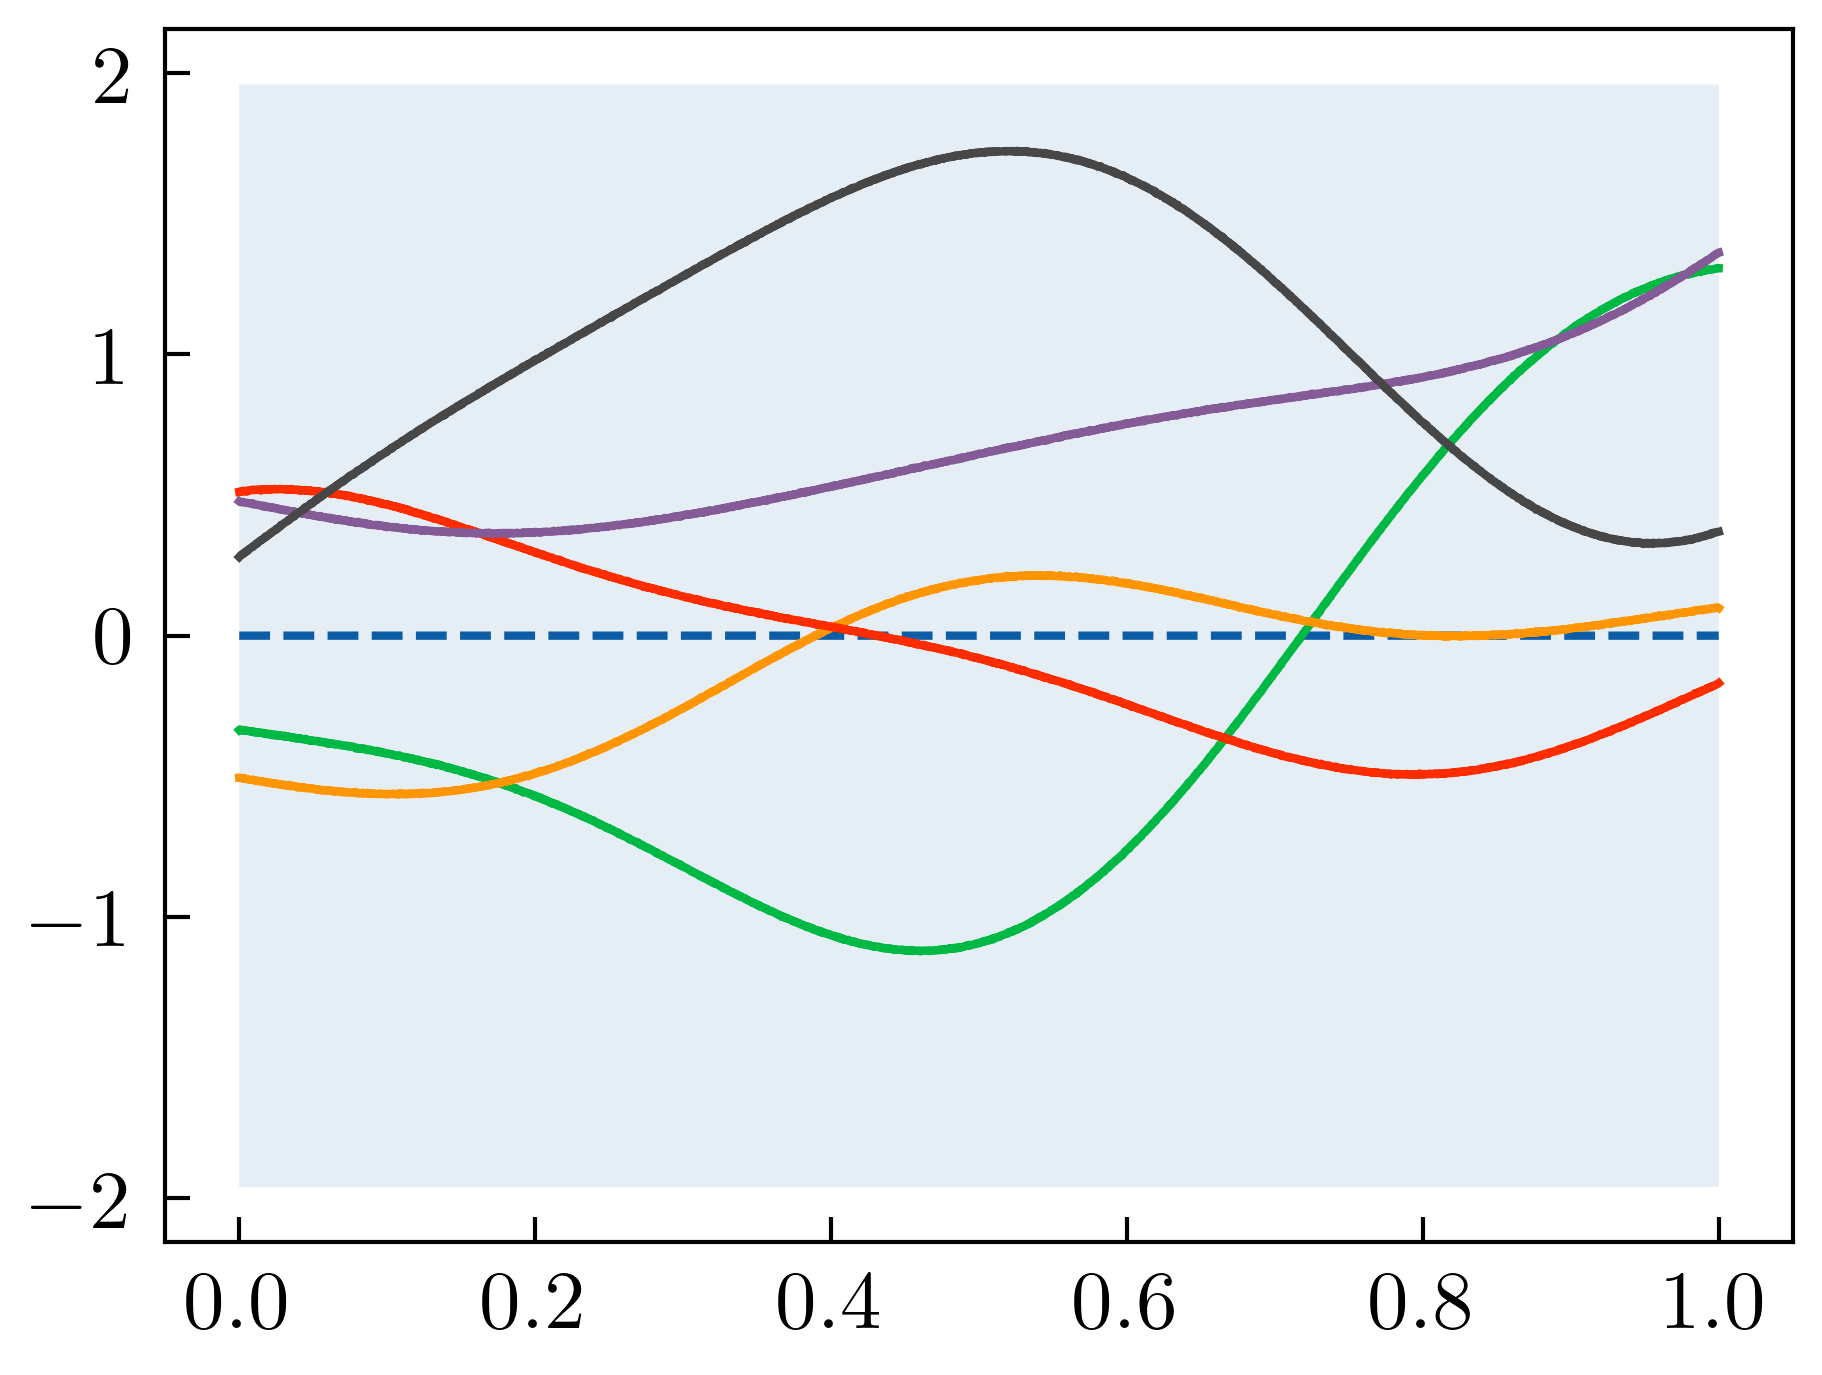

In [47]:
plt.figure(figsize=(3.5, 2.625))
plt.plot(xs[0], model_pred_mean[0], linestyle="--", label="GP Mean")
for i in range(samples.shape[0]):
    plt.plot(xs[0], samples[i])
plt.fill_between(tf.squeeze(xs), tf.squeeze(model_pred_mean) + tf.squeeze(conf_interval), tf.squeeze(model_pred_mean) - tf.squeeze(conf_interval), alpha=0.1, label="GP 95\% CI")
plt.grid(False)
plt.savefig("figs/gp_prior.png", bbox_inches="tight")
plt.show()

In [27]:
search_space = Box([0.0], [1.0])
observer = trieste.objectives.utils.mk_observer(forrester_function)
inputs = tf.constant([[0.05], [0.21], [0.5], [0.62], [0.90]], dtype=tf.float64)
data = observer(inputs)
model.update(data)
model.optimize(data)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [28]:
model_pred_mean, model_pred_var = model.predict(xs)
samples = tf.squeeze(model.sample(xs, 5))
conf_interval = 1.96 * tf.sqrt(model_pred_var)

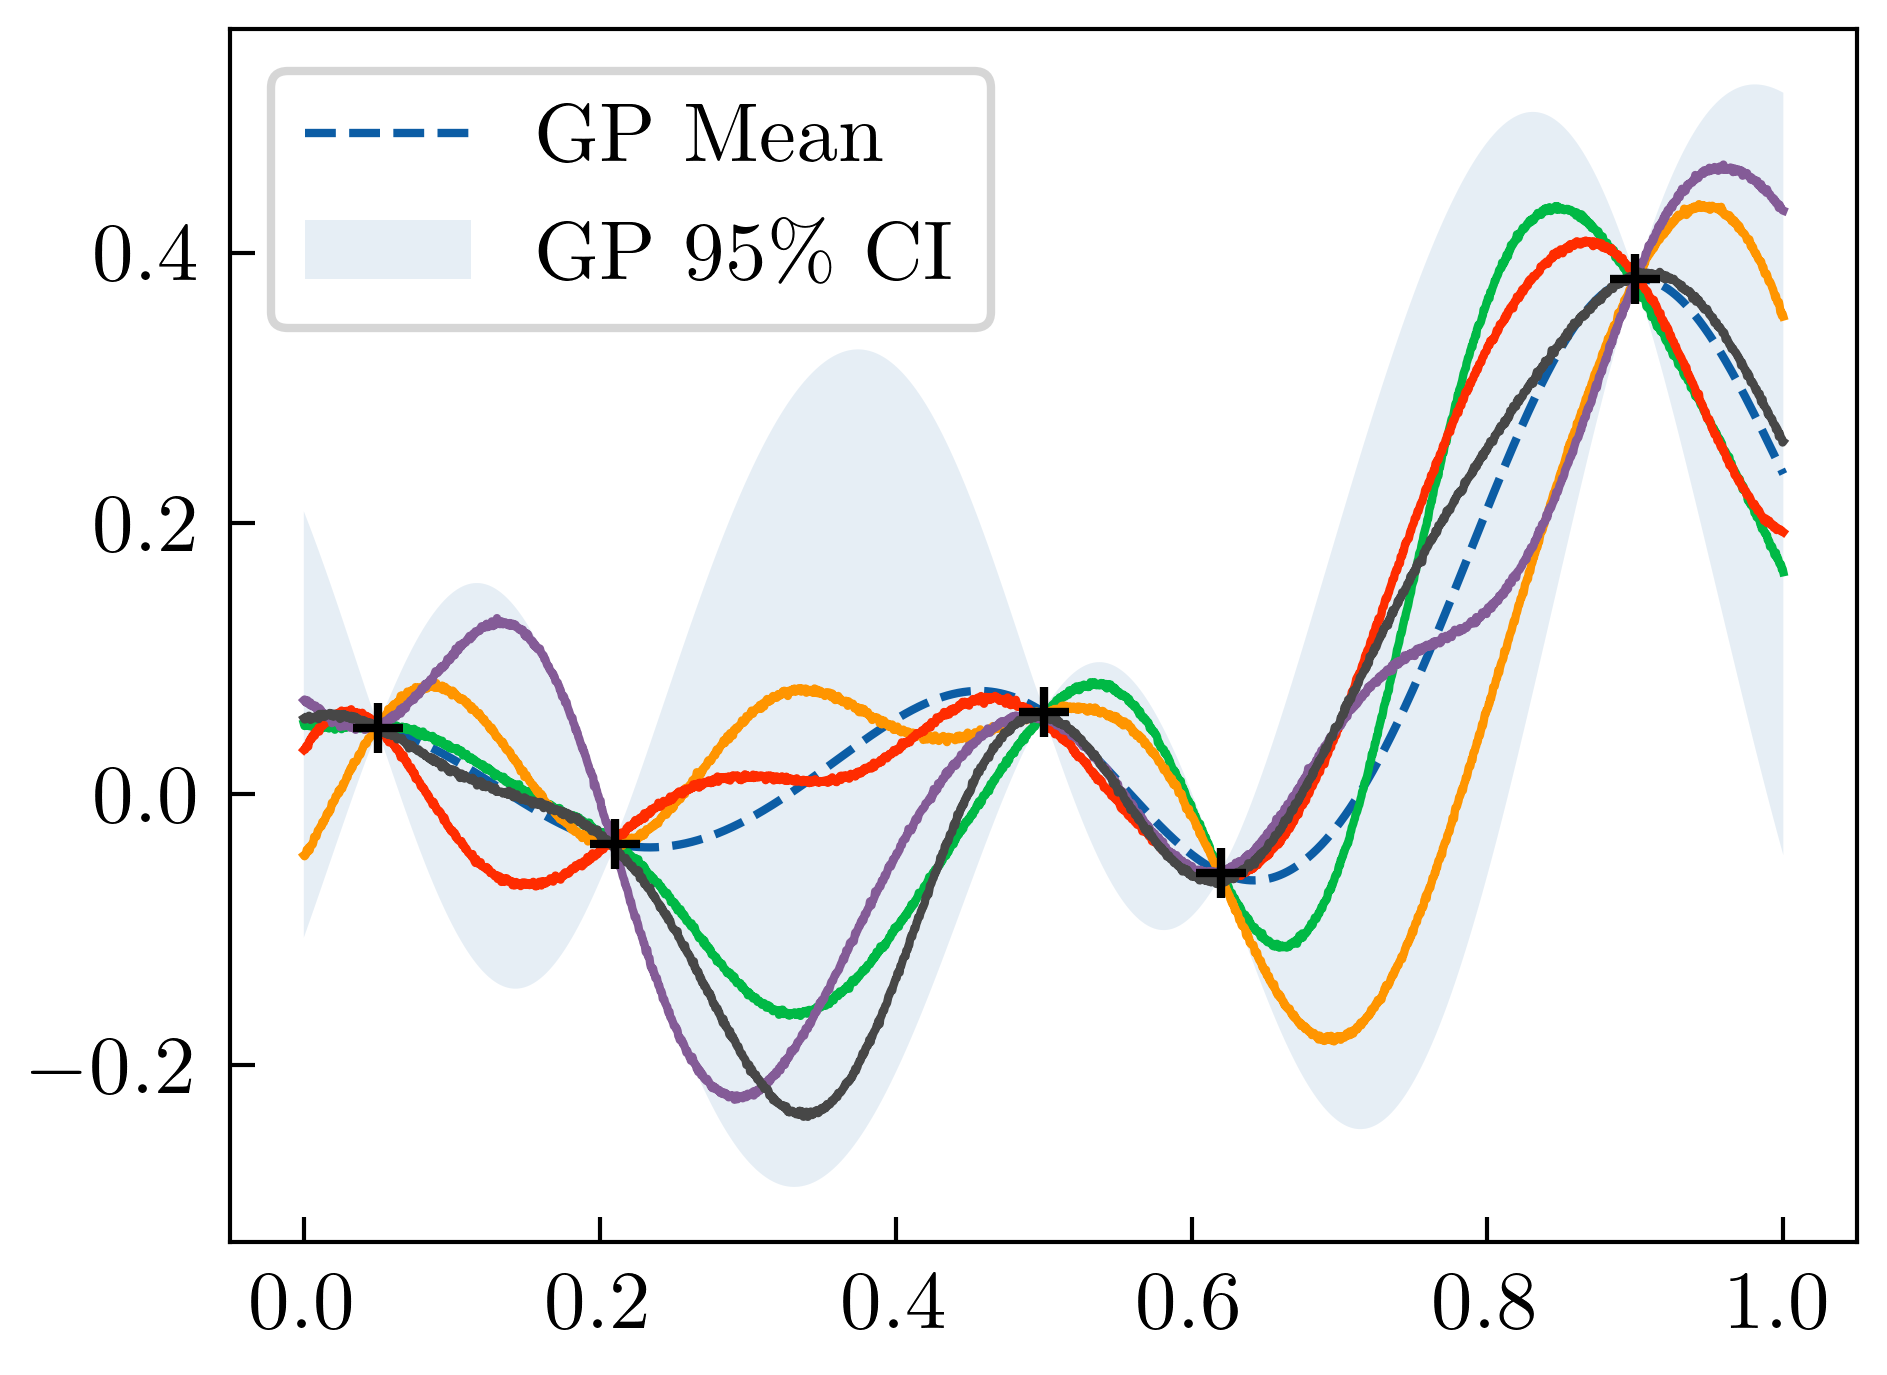

In [31]:
plt.figure(figsize=(3.5, 2.625))
plt.plot(xs[0], model_pred_mean[0], label="GP Mean", linestyle="--")
for i in range(samples.shape[0]):
    plt.plot(xs[0], samples[i])
plt.fill_between(tf.squeeze(xs), tf.squeeze(model_pred_mean) + tf.squeeze(conf_interval), tf.squeeze(model_pred_mean) - tf.squeeze(conf_interval), alpha=0.1, label="GP 95\% CI")
plt.scatter(data.query_points, data.observations, marker="+", color="black", zorder=10)
plt.grid(False)
plt.legend()
plt.savefig("figs/gp_posterior.png", bbox_inches="tight")

### Expected Improvement Plots

In [48]:
def expected_improvement(best_obs, mean, variance):
    standard_dev = tf.sqrt(variance)
    best_obs_vec = tf.cast(tf.repeat(best_obs, mean.shape[0]), dtype=tf.float64)
    psi = scipy.stats.norm.cdf(best_obs_vec, loc=mean, scale=standard_dev)
    exploitation = (best_obs_vec - mean) * psi
    pdf = scipy.stats.norm.pdf(best_obs_vec, loc=mean, scale=standard_dev)
    exploration = variance * pdf
    ei = exploration + exploitation
    return ei

In [49]:
initial_data = (tf.constant([[-1e6]], dtype=tf.float64), tf.constant([[0]], dtype=tf.float64))
model = GaussianProcessRegression(gpflow.models.GPR(initial_data, kernel=gpflow.kernels.SquaredExponential(variance=1, lengthscales=0.3), mean_function=gpflow.mean_functions.Zero(), noise_variance=1e-5), use_decoupled_sampler=True)
search_space = Box([0.0], [1.0])
observer = trieste.objectives.utils.mk_observer(forrester_function)
inputs = tf.constant([[0.05], [0.21], [0.5], [0.62], [0.90]], dtype=tf.float64)
data = observer(inputs)
model.update(data)
model.optimize(data)
model_pred_mean, model_pred_var = model.predict(xs)
conf_interval = 1.96 * tf.sqrt(model_pred_var)
ei = expected_improvement(min(data.observations), tf.squeeze(model_pred_mean), tf.squeeze(model_pred_var))

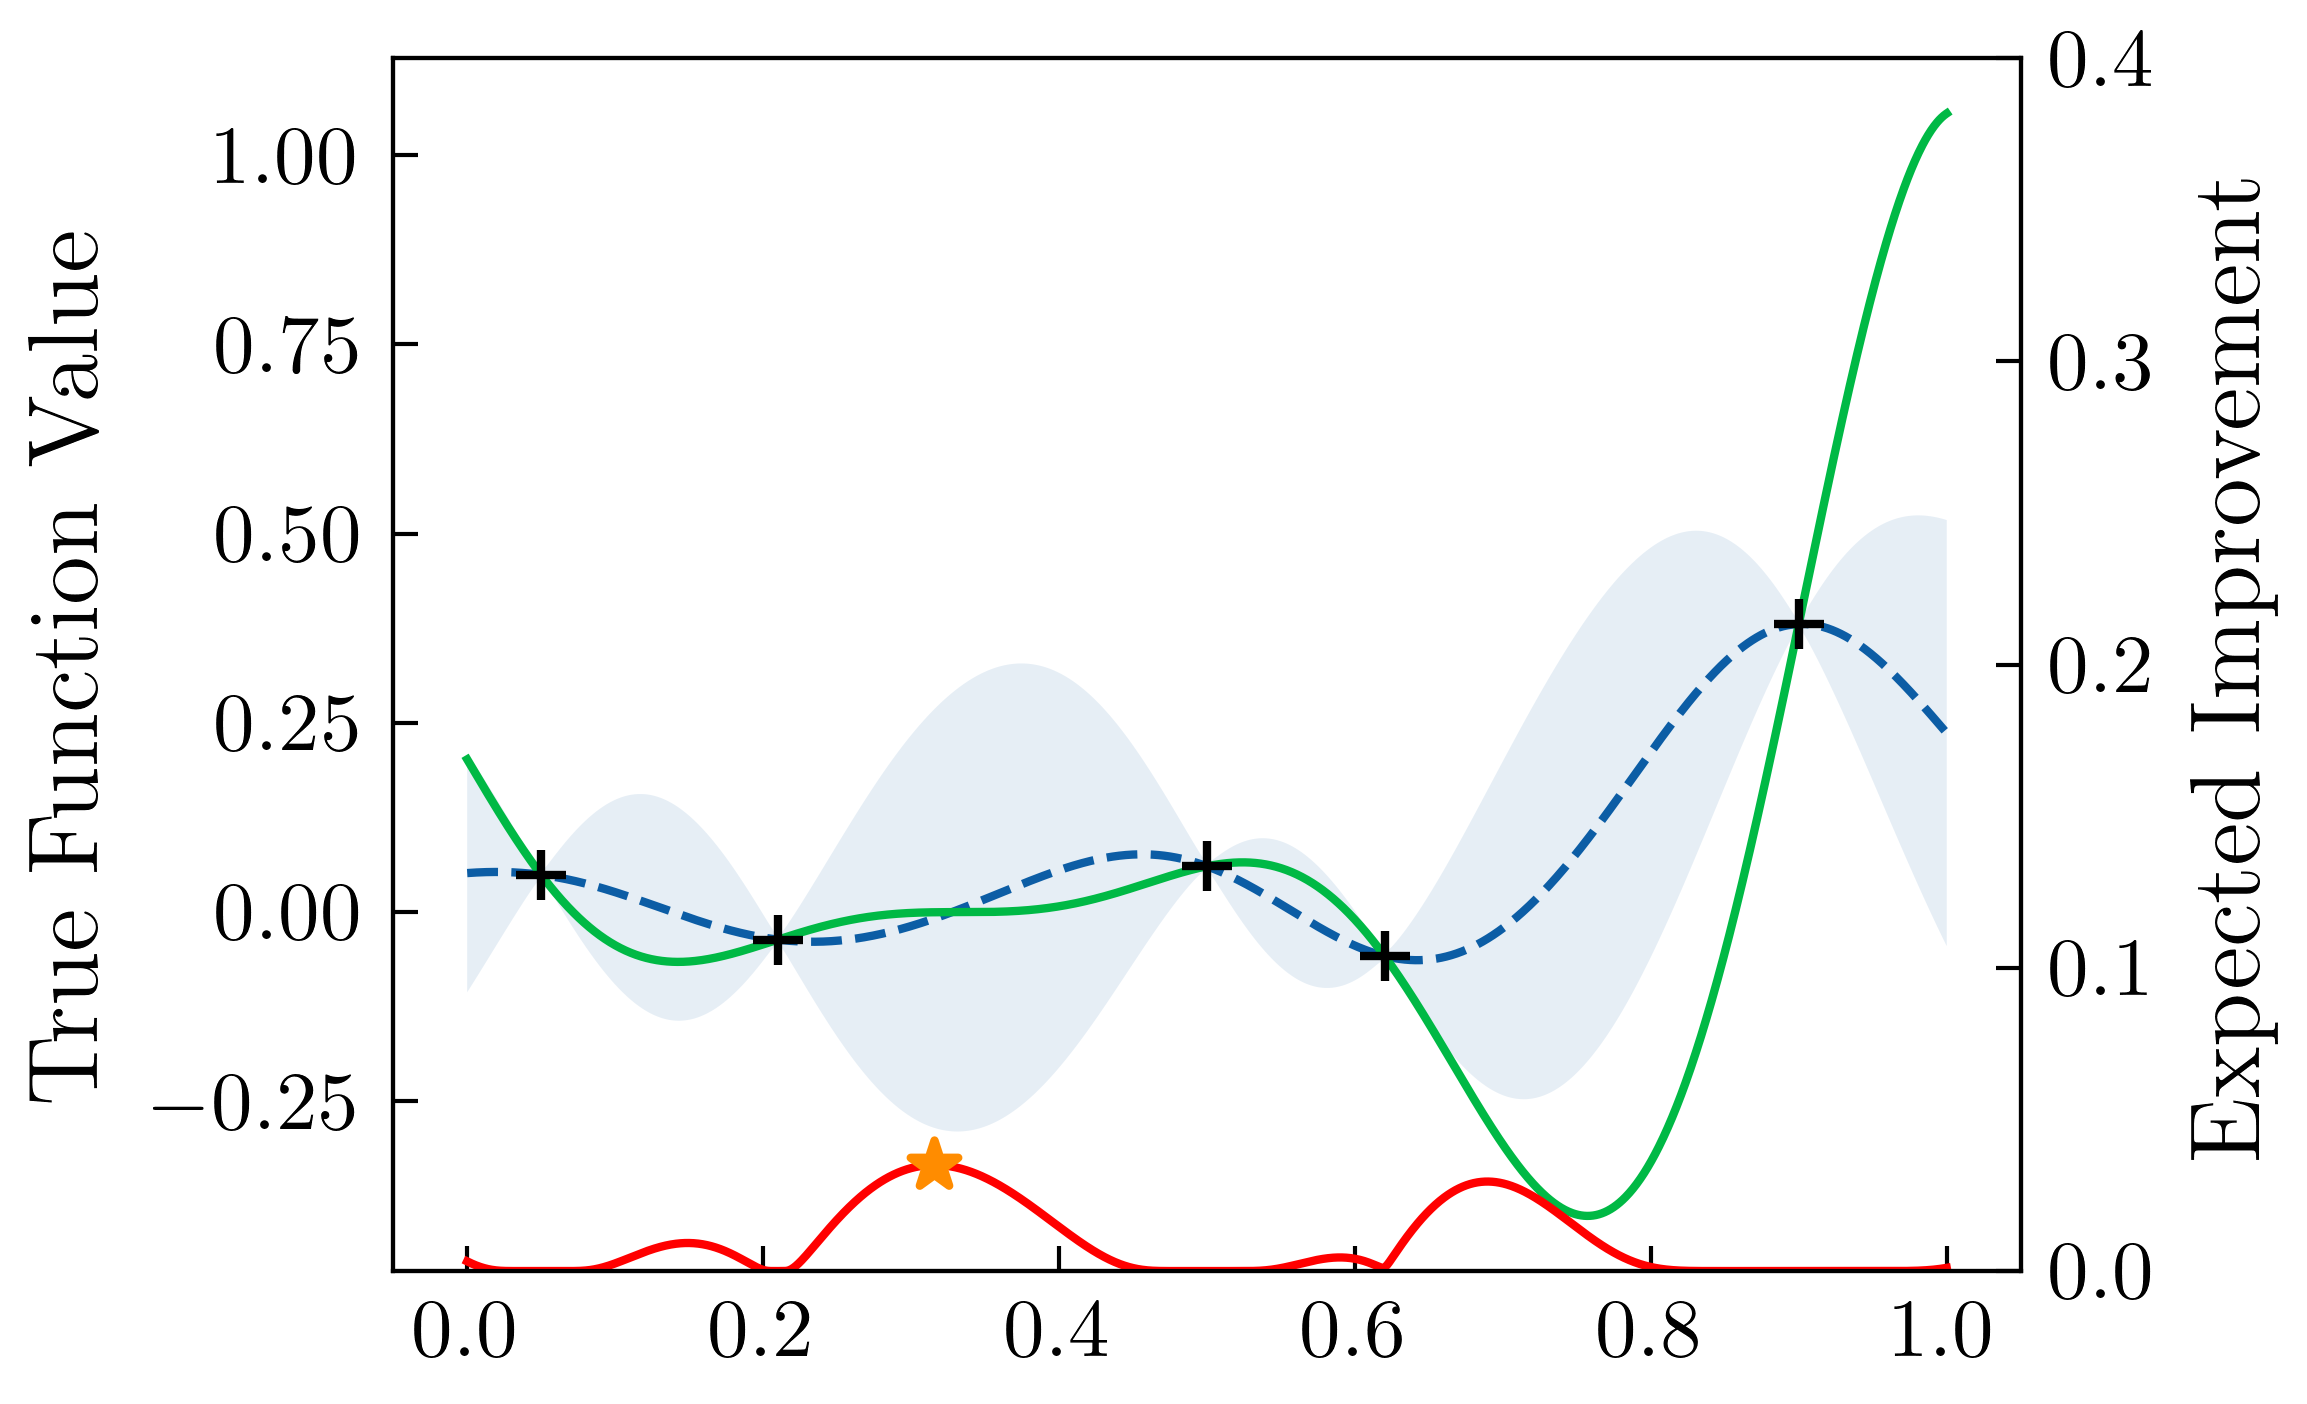

In [50]:
ax = plt.subplot(111)
mean = ax.plot(xs[0], model_pred_mean[0], label="GP Mean", linestyle="--")
posterior = ax.fill_between(tf.squeeze(xs), tf.squeeze(model_pred_mean) + tf.squeeze(conf_interval), tf.squeeze(model_pred_mean) - tf.squeeze(conf_interval), alpha=0.1, label="GP 95\% CI")
ax.scatter(data.query_points, data.observations, marker="+", color="black", zorder=10)
a = ax.plot(xs[0], forrester_ys[0], label="True Function")
ei_ax = ax.twinx()
ei_ax.set_ylim(0,0.4)
ei_ax.plot(xs[0], ei, label="Expected Improvement", color="red")
ei_ax.scatter(xs[0][tf.argmax(ei)], max(ei), marker="*", zorder=10, color="darkorange")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ei_ax.get_legend_handles_labels()
ax.grid(False)
ei_ax.grid(False)
ax.set_ylabel("True Function Value")
ei_ax.set_ylabel("Expected Improvement")
# ax.legend(lines + lines2, labels + labels2)
plt.savefig("figs/bo_start.png", bbox_inches="tight")
plt.show()

In [51]:
new_query_point = xs[0][tf.argmax(ei)][None, ...]
new_observation = observer(new_query_point)
data = data + new_observation
model.update(data)
model.optimize(data)
model_pred_mean, model_pred_var = model.predict(xs)
conf_interval = 1.96 * tf.sqrt(model_pred_var)
ei = expected_improvement(min(data.observations), tf.squeeze(model_pred_mean), tf.squeeze(model_pred_var))

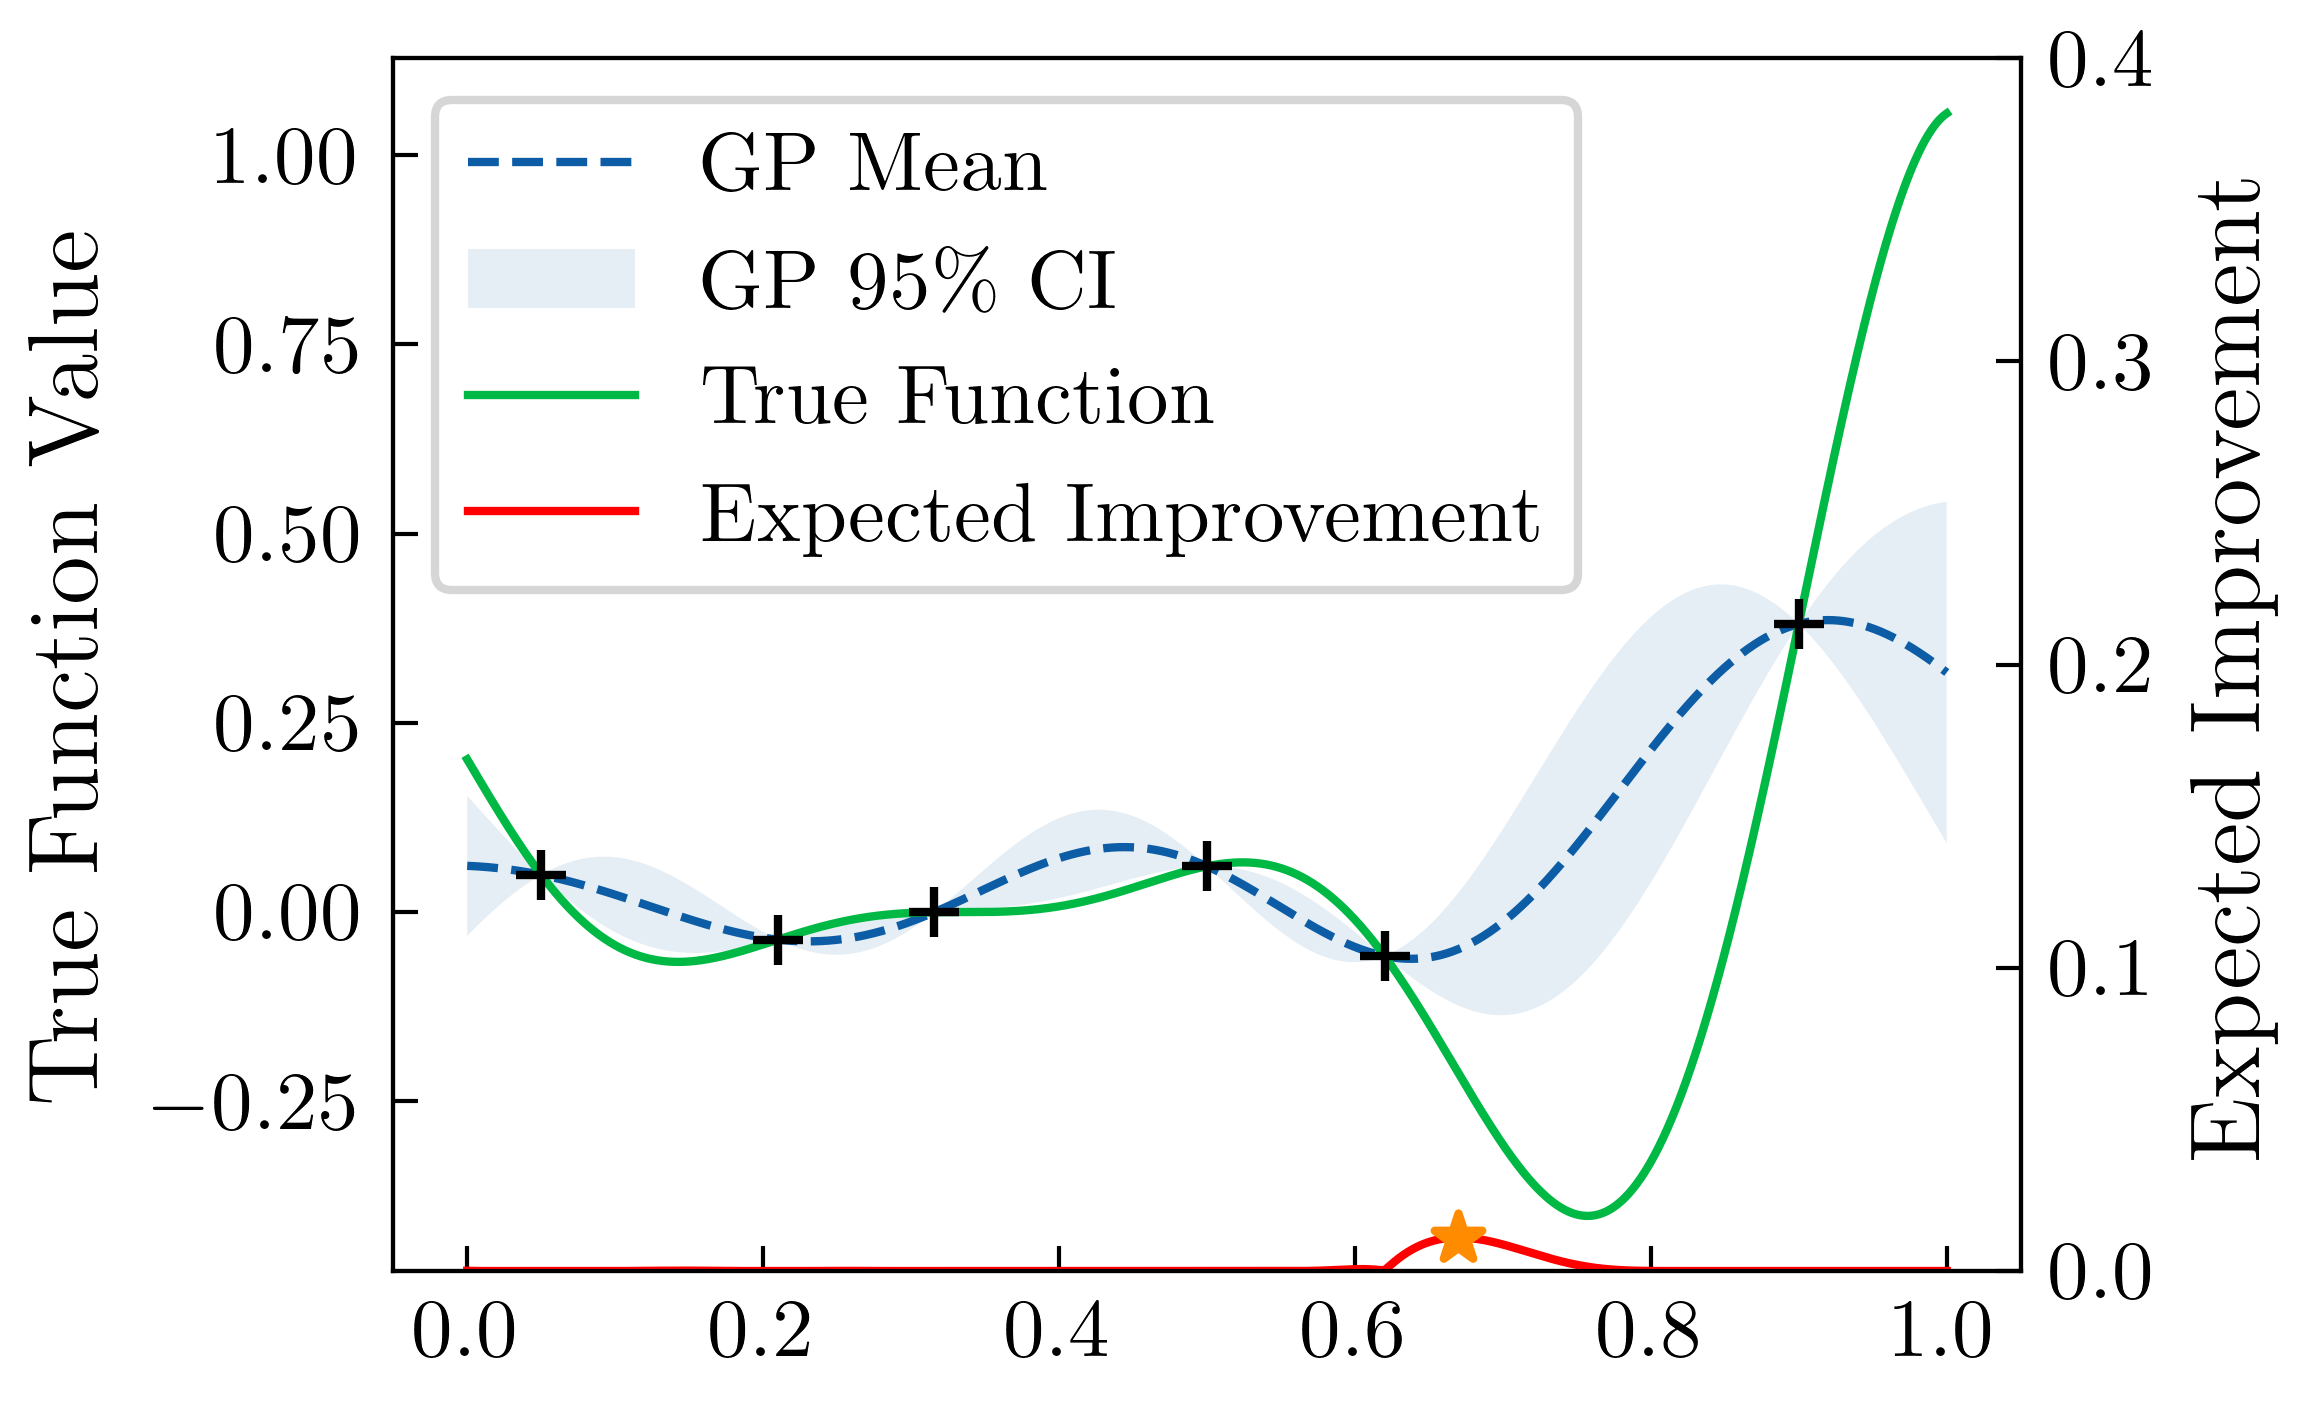

In [52]:
ax = plt.subplot(111)
mean = ax.plot(xs[0], model_pred_mean[0], label="GP Mean", linestyle="--")
posterior = ax.fill_between(tf.squeeze(xs), tf.squeeze(model_pred_mean) + tf.squeeze(conf_interval), tf.squeeze(model_pred_mean) - tf.squeeze(conf_interval), alpha=0.1, label="GP 95\% CI")
ax.scatter(data.query_points, data.observations, marker="+", color="black", zorder=10)
a = ax.plot(xs[0], forrester_ys[0], label="True Function")
ei_ax = ax.twinx()
ei_ax.set_ylim(0,0.4)
ei_ax.plot(xs[0], ei, label="Expected Improvement", color="red")
ei_ax.scatter(xs[0][tf.argmax(ei)], max(ei), marker="*", zorder=10, color="darkorange")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ei_ax.get_legend_handles_labels()
ax.grid(False)
ei_ax.grid(False)
ax.set_ylabel("True Function Value")
ei_ax.set_ylabel("Expected Improvement")
ax.legend(lines + lines2, labels + labels2)
plt.savefig("figs/bo_end.png", bbox_inches="tight")
plt.show()